<a href="https://www.kaggle.com/code/joshuamistal/fraud-detection-model?scriptVersionId=191732560" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

# Models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# # Data Processing Utilities 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

%matplotlib inline
import matplotlib.pyplot as plt

tf.autograph.set_verbosity(0)
np.set_printoptions(precision=2)

2024-08-09 03:57:12.406073: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-09 03:57:12.406207: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-09 03:57:12.534395: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Load Dataset
df = pd.read_csv("/kaggle/input/credit-card-fraud-data/fraud_data.csv")

#Converting date of birth:'dob' and transaction date and time:'trans_date_trans_time' columns to datetime format
df['dob'] = pd.to_datetime(df['dob'], format='%d-%m-%Y')
df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'], format='%d-%m-%Y %H:%M')

#Extracting date and time into separate columns
df['trans_date'] = df['trans_date_trans_time'].dt.date
df['trans_time'] = df['trans_date_trans_time'].dt.time

#Calculating age directly by subtracting year of birth from transaction year
df['age'] = df['trans_date'].apply(lambda x: x.year) - df['dob'].dt.year

#Extracting hour of transaction
df['transaction_hour'] = df['trans_date_trans_time'].dt.hour

#Dropping irrelevant and problematic is_fraud column
df = df.drop(columns=['trans_date_trans_time', 'trans_date', 'dob', 'trans_num','trans_time', 'merchant','state','city'])
df['is_fraud'] = df['is_fraud'].astype(str).str.extract(r'(\d)').fillna(0).astype(int)

# Label encode the categorical variables and set the datatype as integer
categorical_columns = ["category", "job"]
label_encoders = {}
df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoders.setdefault(col.name, LabelEncoder()).fit_transform(col))
df['is_fraud'] = df['is_fraud'].astype(int)

df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14446 entries, 0 to 14445
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   category          14446 non-null  int64  
 1   amt               14446 non-null  float64
 2   lat               14446 non-null  float64
 3   long              14446 non-null  float64
 4   city_pop          14446 non-null  int64  
 5   job               14446 non-null  int64  
 6   merch_lat         14446 non-null  float64
 7   merch_long        14446 non-null  float64
 8   is_fraud          14446 non-null  int64  
 9   age               14446 non-null  int64  
 10  transaction_hour  14446 non-null  int32  
dtypes: float64(5), int32(1), int64(5)
memory usage: 1.2 MB


,category,amt,lat,long,city_pop,job,merch_lat,merch_long,is_fraud,age,transaction_hour
0,3,14.37,64.7556,-165.6723,145,1,65.654142,-164.722603,1,80,0
1,11,966.11,64.7556,-165.6723,145,1,65.468863,-165.473127,1,80,15
2,9,49.61,64.7556,-165.6723,145,1,65.347667,-165.914542,1,80,22
3,4,295.26,64.7556,-165.6723,145,1,64.445035,-166.080207,1,80,23
4,5,18.17,64.7556,-165.6723,145,1,65.447094,-165.446843,1,80,23


In [3]:
# Dataset  
features = [x for x in df.columns if x not in ["is_fraud"]] 
X = df[features].values
y = df["is_fraud"].values

# Splitting the Dataset
RANDOM_STATE = 1
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size = 0.8, random_state = 1, shuffle = True)

In [4]:
print(f'train samples: {len(X_train)}')
print(f'validation samples: {len(X_val)}')
print(f'target proportion: {sum(y_train)/len(y_train):.4f}')

train samples: 11556
validation samples: 2890
target proportion: 0.1285


In [5]:
# Applying Feature Scaling to X 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# 1. Decision Tree Model Implementation

In [6]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [None, 2, 4, 6, 8, 16, 32] # None means that there is no depth limit.

param_grid = {
    'min_samples_split': min_samples_split_list,
    'max_depth': max_depth_list
}

RANDOM_STATE = 1

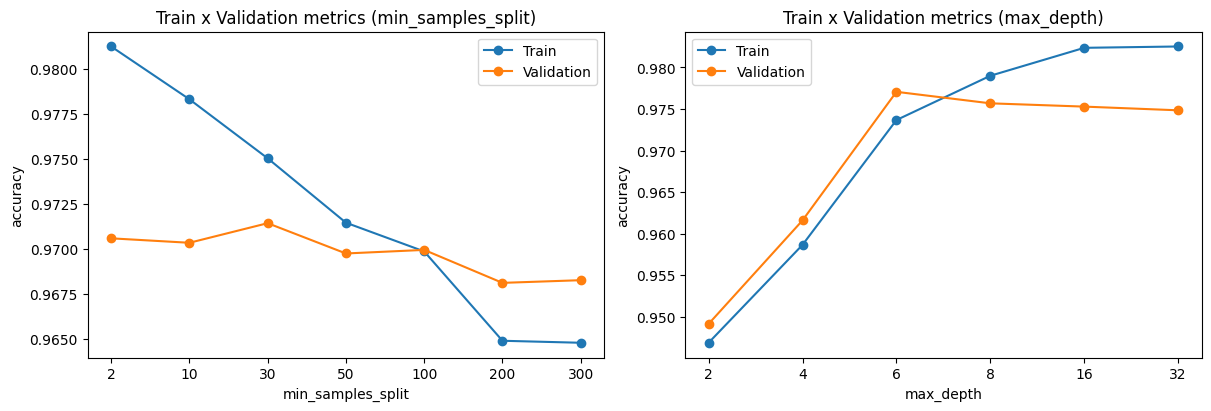

In [7]:
# Initialize lists to store accuracies for each combination
accuracy_list_train = []
accuracy_list_val = []

# Nested loop to iterate over both min_samples_split and max_depth
for min_samples_split in min_samples_split_list:
    for max_depth in max_depth_list:
        # Fit the model with both parameters
        model = DecisionTreeClassifier(min_samples_split=min_samples_split,
                                       max_depth=max_depth,
                                       random_state=RANDOM_STATE).fit(X_train, y_train) 
        # Predictions
        predictions_train = model.predict(X_train)
        predictions_val = model.predict(X_val)
        
        # Calculate accuracy for training and validation datasets
        accuracy_train = accuracy_score(predictions_train, y_train)
        accuracy_val = accuracy_score(predictions_val, y_val)
        
        # Store the results
        accuracy_list_train.append((min_samples_split, max_depth, accuracy_train))
        accuracy_list_val.append((min_samples_split, max_depth, accuracy_val))

df_train_results = pd.DataFrame(accuracy_list_train, columns=['min_samples_split', 'max_depth', 'accuracy_train'])
df_val_results = pd.DataFrame(accuracy_list_val, columns=['min_samples_split', 'max_depth', 'accuracy_val'])

# Extract accuracy for each parameter individually
train_acc_min_samples_split = []
val_acc_min_samples_split = []

train_acc_max_depth = []
val_acc_max_depth = []

# For min_samples_split (keeping max_depth constant)
for min_samples_split in min_samples_split_list:
    train_acc_min_samples_split.append(df_train_results[df_train_results['min_samples_split'] == min_samples_split]['accuracy_train'].mean())
    val_acc_min_samples_split.append(df_val_results[df_val_results['min_samples_split'] == min_samples_split]['accuracy_val'].mean())

# For max_depth (keeping min_samples_split constant)
for max_depth in max_depth_list:
    train_acc_max_depth.append(df_train_results[df_train_results['max_depth'] == max_depth]['accuracy_train'].mean())
    val_acc_max_depth.append(df_val_results[df_val_results['max_depth'] == max_depth]['accuracy_val'].mean())

# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12, 4))

# Plot for min_samples_split
ax1.set_title('Train x Validation metrics (min_samples_split)')
ax1.set_xlabel('min_samples_split')
ax1.set_ylabel('accuracy')
ax1.set_xticks(range(len(min_samples_split_list)))
ax1.set_xticklabels(min_samples_split_list)
ax1.plot(train_acc_min_samples_split, marker='o')
ax1.plot(val_acc_min_samples_split, marker='o')
ax1.legend(['Train', 'Validation'])

# Plot for max_depth
ax2.set_title('Train x Validation metrics (max_depth)')
ax2.set_xlabel('max_depth')
ax2.set_ylabel('accuracy')
ax2.set_xticks(range(len(max_depth_list)))
ax2.set_xticklabels(max_depth_list)
ax2.plot(train_acc_max_depth, marker='o')
ax2.plot(val_acc_max_depth, marker='o')
ax2.legend(['Train', 'Validation'])

plt.show()

In [8]:
# Example: We can choose our hyperparameter to be min_samples_split = 30, max_depth = 6
decision_tree_model = DecisionTreeClassifier(min_samples_split = 30,
                                             max_depth = 6,
                                             random_state = RANDOM_STATE).fit(X_train,y_train)

In [9]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(decision_tree_model.predict(X_val),y_val):.4f}")

Metrics train:
	Accuracy score: 0.9762
Metrics validation:
	Accuracy score: 0.9785


# 2. Random Tree Model Implementation 

In [10]:
min_samples_split_list = [2,10, 30, 50, 100, 200, 300] ## If the number is an integer, then it is the actual quantity of samples,
max_depth_list = [None, 2, 4, 6, 8, 16, 32] # None means that there is no depth limit.
n_estimators_list = [10, 50, 100, 200]

param_grid = {
    'min_samples_split': min_samples_split_list,
    'max_depth': max_depth_list, 
    'n_estimators': n_estimators_list
}

In [11]:
#Initializing the model
rf = RandomForestClassifier(random_state=7)

#Setting up the GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, n_jobs = -1, cv= 5 , verbose = 2)

# Fit and train the grid data 
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 196 candidates, totalling 980 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=50; total time=   1.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=   4.8s
[CV] END max_depth=None, min_samples_split=10, n_estimators=10; total time=   0.2s
[CV] END max_depth=None, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_split=10, n_estimators=10; total time=   0.4s
[CV] END max_depth=None, min_samples_split=10, n_estimators=10; total time=   0.3s
[CV] END max_depth=None, min_samples_split=10, n_estimators=50; total time=   1.6s
[CV] END max_depth=None, mi

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=7), n_jobs=-1,
             param_grid={'max_depth': [None, 2, 4, 6, 8, 16, 32],
                         'min_samples_split': [2, 10, 30, 50, 100, 200, 300],
                         'n_estimators': [10, 50, 100, 200]},
             verbose=2)

In [12]:
#Output of the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 0.9778467731430395


In [13]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(grid_search.predict(X_train),y_train):.4f}")
print(f"Metrics validation:\n\tAccuracy score: {accuracy_score(grid_search.predict(X_val),y_val):.4f}")
confusion = confusion_matrix(y_val, grid_search.predict(X_val)) #confusion matrix
print(confusion)
report = classification_report(y_val, grid_search.predict(X_val), output_dict=True)
print(f"Metrics validation (classification report):")
pd.DataFrame(report).transpose()

Metrics train:
	Accuracy score: 0.9999
Metrics validation:
	Accuracy score: 0.9830
[[2513   17]
 [  32  328]]
Metrics validation (classification report):


,precision,recall,f1-score,support
0,0.987426,0.993281,0.990345,2530.000000
1,0.950725,0.911111,0.930496,360.000000
accuracy,0.983045,0.983045,0.983045,0.983045
macro avg,0.969075,0.952196,0.960421,2890.000000
weighted avg,0.982854,0.983045,0.982890,2890.000000


[CV] END max_depth=8, min_samples_split=200, n_estimators=100; total time=   1.9s
[CV] END max_depth=8, min_samples_split=200, n_estimators=200; total time=   3.9s
[CV] END max_depth=8, min_samples_split=200, n_estimators=200; total time=   3.9s
[CV] END max_depth=8, min_samples_split=300, n_estimators=100; total time=   1.9s
[CV] END max_depth=8, min_samples_split=300, n_estimators=200; total time=   3.7s
[CV] END .max_depth=16, min_samples_split=2, n_estimators=10; total time=   0.2s
[CV] END .max_depth=16, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END .max_depth=16, min_samples_split=2, n_estimators=50; total time=   1.2s
[CV] END max_depth=16, min_samples_split=2, n_estimators=100; total time=   2.4s
[CV] END max_depth=16, min_samples_split=2, n_estimators=200; total time=   5.1s
[CV] END max_depth=16, min_samples_split=2, n_estimators=200; total time=   4.8s
[CV] END max_depth=16, min_samples_split=10, n_estimators=100; total time=   2.4s
[CV] END max_depth=16,

## Summary of the Model's Performance:

**Accuracy (98.30%)**: Indicates that the model correctly classifies 98.30% of the total instances.

**Precision (95.07%)**: Indicates that out of all predicted positive instances, 95.07% are actually positive.

**Recall (91.11%)**: Indicates that out of all actual positive instances, the model correctly identifies 91.11%.

**F1 Score (93.04%)**: This is a harmonic mean of precision and recall, providing a single metric that balances both.

**Specificity (99.33%)**: Indicates that out of all actual negative instances, the model correctly identifies 99.45%


# 3. XGBoost Implementation

In [ ]:
xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1,verbosity = 2, random_state = RANDOM_STATE)
xgb_model.fit(X_train,y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 20)

In [ ]:
xgb_model.best_iteration

In [ ]:
print(f"Metrics train:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_train),y_train):.4f}\nMetrics test:\n\tAccuracy score: {accuracy_score(xgb_model.predict(X_val),y_val):.4f}")